## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/02_Point/'
fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

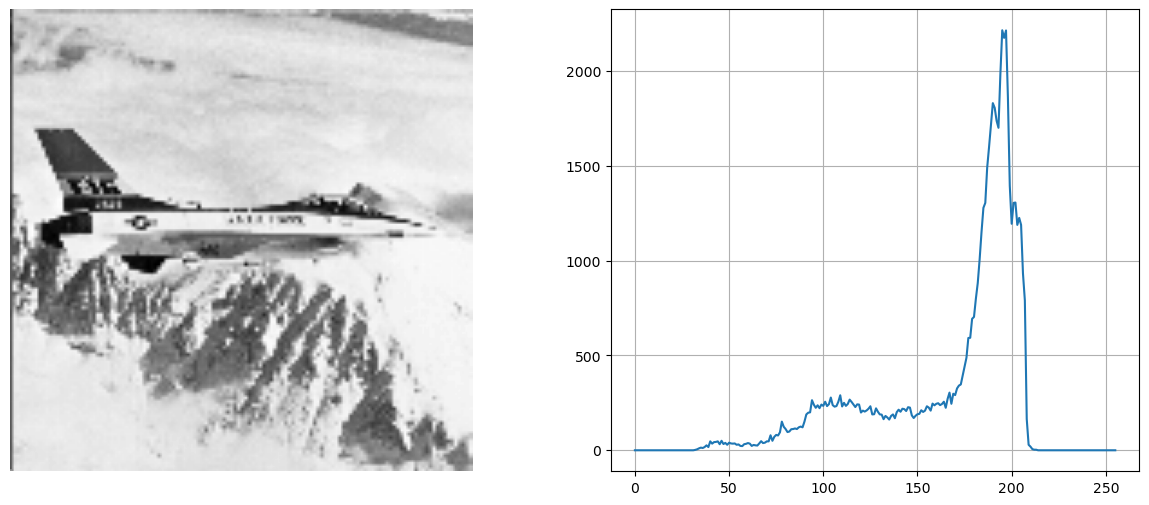

In [2]:
jet = cv2.imread('jet.bmp', cv2.IMREAD_GRAYSCALE)
jet_hist = cv2.calcHist([jet], [0], None, [256], [0, 256])

cmap = 'gray'

fig, (jet_ax, hist_ax) = plt.subplots(1, 2, figsize=(15, 6))
jet_ax.imshow(jet, cmap=cmap)
jet_ax.axis('off')
hist_ax.plot(jet_hist)
hist_ax.grid()

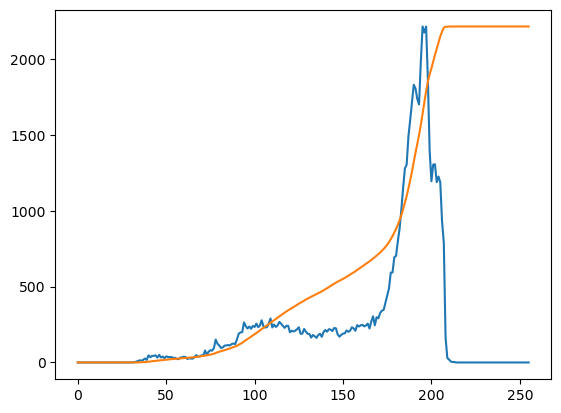

In [3]:
def cumulative_hist(hist):
    max_value = hist.max()
    cumulative = np.cumsum(hist)
    cumulative = cumulative / cumulative.max() * max_value
    return cumulative


bbhe_mean = jet.mean()
cumulative = cumulative_hist(jet_hist)
half = cumulative.max() / 2

dsihe_arg = np.argmin(np.abs(cumulative - half))
plt.plot(jet_hist)
plt.plot(cumulative)

186


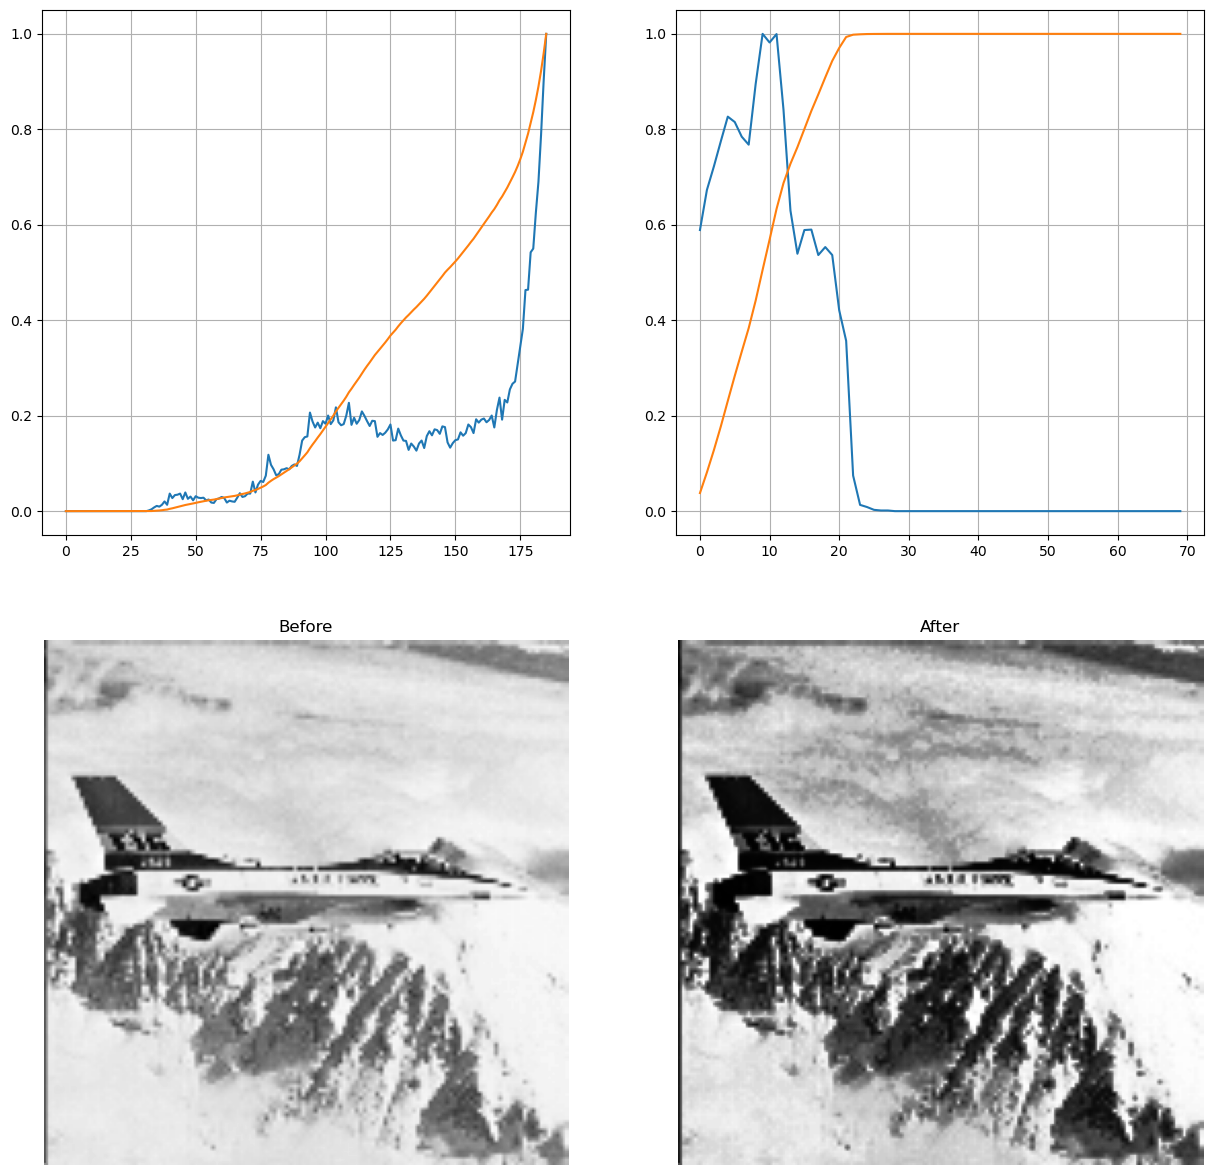

In [4]:
dsihe_hist_1 = jet_hist[:dsihe_arg].copy()
dsihe_hist_2 = jet_hist[dsihe_arg:].copy()
dsihe_hist_1 /= dsihe_hist_1.max()
dsihe_hist_2 /= dsihe_hist_2.max()

fig, ((h1, h2), (im1, im2)) = plt.subplots(2, 2, figsize=(15, 15))
h1.grid()
h2.grid()
im1.axis('off')
im2.axis('off')

h1.plot(dsihe_hist_1)
h1.plot(dsihe_c1 := cumulative_hist(dsihe_hist_1))
h2.plot(dsihe_hist_2)
h2.plot(dsihe_c2 := cumulative_hist(dsihe_hist_2))
print(dsihe_arg)
dsihe_c1_n = dsihe_c1 * dsihe_arg
dsihe_c2_n = dsihe_arg + 1 + (255 - dsihe_arg - 1) * dsihe_c2

lut = np.concatenate([dsihe_c1_n, dsihe_c2_n])
jet_lut = cv2.LUT(jet, lut)

im1.set_title("Before")
im1.imshow(jet, cmap=cmap)
im2.set_title("After")
im2.imshow(jet_lut, cmap=cmap)

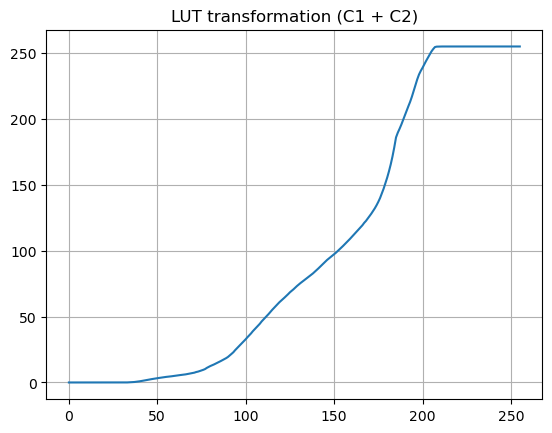

In [5]:
plt.plot(lut)
plt.title("LUT transformation (C1 + C2)")
plt.grid()

Text(0.5, 1.0, 'DSIHE')

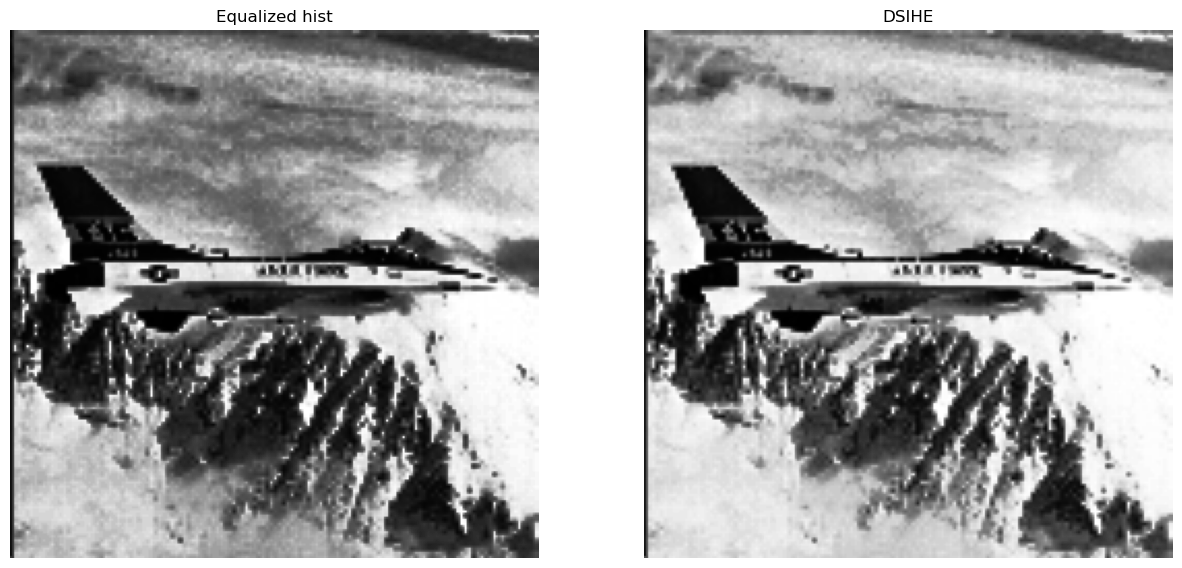

In [6]:
eq_hist = cv2.equalizeHist(jet)
fig, (im1, im2) = plt.subplots(1, 2, figsize=(15, 7))
im1.axis('off')
im2.axis('off')

im1.imshow(eq_hist, cmap=cmap)
im1.set_title("Equalized hist")
im2.imshow(jet_lut, cmap=cmap)
im2.set_title("DSIHE")